In [41]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import numpy as np
from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
)
from monai.utils import set_determinism

print_config()

MONAI version: 1.1.0
Numpy version: 1.21.5
Pytorch version: 1.13.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/madziegielewska/anaconda3/envs/studia/lib/python3.7/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.2.0
Tensorboard version: 2.12.0a20230106
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.13.1a0
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 1.3.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/l

In [24]:
torch.cuda.empty_cache()

In [25]:
root_dir = ""
data_dir = "preprocessed_data"

In [26]:
set_determinism(seed=0)

In [27]:
class_names = sorted(x for x in os.listdir(data_dir)
                     if os.path.isdir(os.path.join(data_dir, x)))
num_class = len(class_names)
image_files = [
    [
        os.path.join(data_dir, class_names[i], x)
        for x in os.listdir(os.path.join(data_dir, class_names[i]))
    ]
    for i in range(num_class)
]
num_each = [len(image_files[i]) for i in range(num_class)]
image_files_list = []
image_class = []
for i in range(num_class):
    image_files_list.extend(image_files[i])
    image_class.extend([i] * num_each[i])
num_total = len(image_class)
image_width, image_height = PIL.Image.open(image_files_list[0]).size

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Total image count: 1800
Image dimensions: 112 x 112
Label names: ['depression', 'no_depression']
Label counts: [1275, 525]


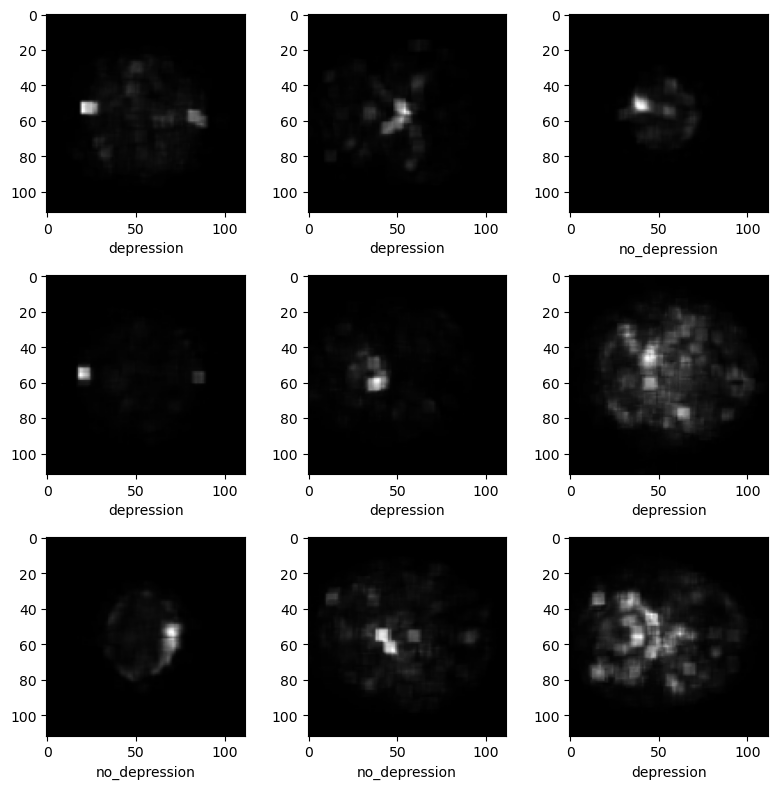

In [28]:
plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(num_total, size=9)):
    im = PIL.Image.open(image_files_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_class[k]])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()

In [29]:
val_frac = 0.1
test_frac = 0.1
length = len(image_files_list)
indices = np.arange(length)
np.random.shuffle(indices)

test_split = int(test_frac * length)
val_split = int(val_frac * length) + test_split
test_indices = indices[:test_split]
val_indices = indices[test_split:val_split]
train_indices = indices[val_split:]

train_x = [image_files_list[i] for i in train_indices]
train_y = [image_class[i] for i in train_indices]
val_x = [image_files_list[i] for i in val_indices]
val_y = [image_class[i] for i in val_indices]
test_x = [image_files_list[i] for i in test_indices]
test_y = [image_class[i] for i in test_indices]

print(
    f"Training count: {len(train_x)}, Validation count: "
    f"{len(val_x)}, Test count: {len(test_x)}")

Training count: 1440, Validation count: 180, Test count: 180


In [30]:
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ScaleIntensity()
    ]
)

val_transforms = Compose(
    [LoadImage(image_only=True), EnsureChannelFirst(), ScaleIntensity()])

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=num_class)])

In [31]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]


train_ds = Dataset(train_x, train_y, train_transforms)
train_loader = DataLoader(
    train_ds, batch_size=15, shuffle=True, num_workers=12)

val_ds = Dataset(val_x, val_y, val_transforms)
val_loader = DataLoader(
    val_ds, batch_size=15, num_workers=12)

test_ds = Dataset(test_x, test_y, val_transforms)
test_loader = DataLoader(
    test_ds, batch_size=15, num_workers=12)

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet121(spatial_dims=2, in_channels=1,out_channels=num_class).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 10
val_interval = 1
auc_metric = ROCAUCMetric()

In [43]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

----------
epoch 1/10


/home/madziegielewska/anaconda3/envs/studia/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


1/96, train_loss: 0.6947
2/96, train_loss: 0.7058
3/96, train_loss: 0.5634
4/96, train_loss: 0.5488
5/96, train_loss: 0.6590
6/96, train_loss: 0.7444
7/96, train_loss: 0.6398
8/96, train_loss: 0.5592
9/96, train_loss: 0.5626
10/96, train_loss: 0.7114
11/96, train_loss: 0.5905
12/96, train_loss: 0.6103
13/96, train_loss: 0.6950
14/96, train_loss: 0.6839
15/96, train_loss: 0.5469
16/96, train_loss: 0.6958
17/96, train_loss: 0.6686
18/96, train_loss: 0.7182
19/96, train_loss: 0.6589
20/96, train_loss: 0.6184
21/96, train_loss: 0.7087
22/96, train_loss: 0.6089
23/96, train_loss: 0.6553
24/96, train_loss: 0.6321
25/96, train_loss: 0.6096
26/96, train_loss: 0.7013
27/96, train_loss: 0.7498
28/96, train_loss: 0.6160
29/96, train_loss: 0.5938
30/96, train_loss: 0.6264
31/96, train_loss: 0.7018
32/96, train_loss: 0.5171
33/96, train_loss: 0.5952
34/96, train_loss: 0.6303
35/96, train_loss: 0.5756
36/96, train_loss: 0.6137
37/96, train_loss: 0.6445
38/96, train_loss: 0.5893
39/96, train_loss: 0.

13/96, train_loss: 0.4850
14/96, train_loss: 0.5397
15/96, train_loss: 0.4545
16/96, train_loss: 0.8702
17/96, train_loss: 0.4509
18/96, train_loss: 0.5539
19/96, train_loss: 0.6332
20/96, train_loss: 0.5438
21/96, train_loss: 0.5877
22/96, train_loss: 0.7537
23/96, train_loss: 0.6602
24/96, train_loss: 0.4051
25/96, train_loss: 0.5656
26/96, train_loss: 0.7167
27/96, train_loss: 0.6727
28/96, train_loss: 0.5958
29/96, train_loss: 0.6062
30/96, train_loss: 0.5731
31/96, train_loss: 0.5033
32/96, train_loss: 0.4985
33/96, train_loss: 0.6413
34/96, train_loss: 0.4545
35/96, train_loss: 0.5920
36/96, train_loss: 0.5192
37/96, train_loss: 0.5637
38/96, train_loss: 0.7500
39/96, train_loss: 0.4571
40/96, train_loss: 0.5999
41/96, train_loss: 0.5476
42/96, train_loss: 0.4914
43/96, train_loss: 0.4867
44/96, train_loss: 0.7100
45/96, train_loss: 0.5812
46/96, train_loss: 0.4820
47/96, train_loss: 0.5916
48/96, train_loss: 0.6025
49/96, train_loss: 0.5190
50/96, train_loss: 0.5988
51/96, train

23/96, train_loss: 0.5033
24/96, train_loss: 0.5581
25/96, train_loss: 0.5295
26/96, train_loss: 0.4926
27/96, train_loss: 0.3817
28/96, train_loss: 0.3693
29/96, train_loss: 0.5762
30/96, train_loss: 0.5071
31/96, train_loss: 0.3991
32/96, train_loss: 0.6759
33/96, train_loss: 0.5837
34/96, train_loss: 0.6530
35/96, train_loss: 0.4319
36/96, train_loss: 0.4835
37/96, train_loss: 0.5982
38/96, train_loss: 0.4290
39/96, train_loss: 0.3686
40/96, train_loss: 0.5466
41/96, train_loss: 0.6914
42/96, train_loss: 0.5069
43/96, train_loss: 0.5943
44/96, train_loss: 0.5283
45/96, train_loss: 0.4068
46/96, train_loss: 0.3971
47/96, train_loss: 0.4577
48/96, train_loss: 0.5772
49/96, train_loss: 0.5227
50/96, train_loss: 0.3398
51/96, train_loss: 0.5242
52/96, train_loss: 0.4507
53/96, train_loss: 0.5543
54/96, train_loss: 0.5110
55/96, train_loss: 0.4729
56/96, train_loss: 0.4488
57/96, train_loss: 0.4881
58/96, train_loss: 0.4123
59/96, train_loss: 0.5404
60/96, train_loss: 0.5151
61/96, train

34/96, train_loss: 0.3775
35/96, train_loss: 0.3990
36/96, train_loss: 0.3601
37/96, train_loss: 0.3318
38/96, train_loss: 0.3157
39/96, train_loss: 0.3978
40/96, train_loss: 0.4583
41/96, train_loss: 0.3931
42/96, train_loss: 0.3554
43/96, train_loss: 0.3486
44/96, train_loss: 0.4840
45/96, train_loss: 0.3468
46/96, train_loss: 0.3307
47/96, train_loss: 0.3736
48/96, train_loss: 0.4423
49/96, train_loss: 0.5485
50/96, train_loss: 0.3480
51/96, train_loss: 0.5263
52/96, train_loss: 0.4004
53/96, train_loss: 0.4174
54/96, train_loss: 0.4055
55/96, train_loss: 0.4431
56/96, train_loss: 0.4000
57/96, train_loss: 0.5182
58/96, train_loss: 0.3378
59/96, train_loss: 0.3705
60/96, train_loss: 0.3537
61/96, train_loss: 0.3369
62/96, train_loss: 0.3339
63/96, train_loss: 0.3693
64/96, train_loss: 0.2990
65/96, train_loss: 0.4689
66/96, train_loss: 0.3545
67/96, train_loss: 0.3288
68/96, train_loss: 0.4406
69/96, train_loss: 0.4254
70/96, train_loss: 0.2774
71/96, train_loss: 0.3287
72/96, train

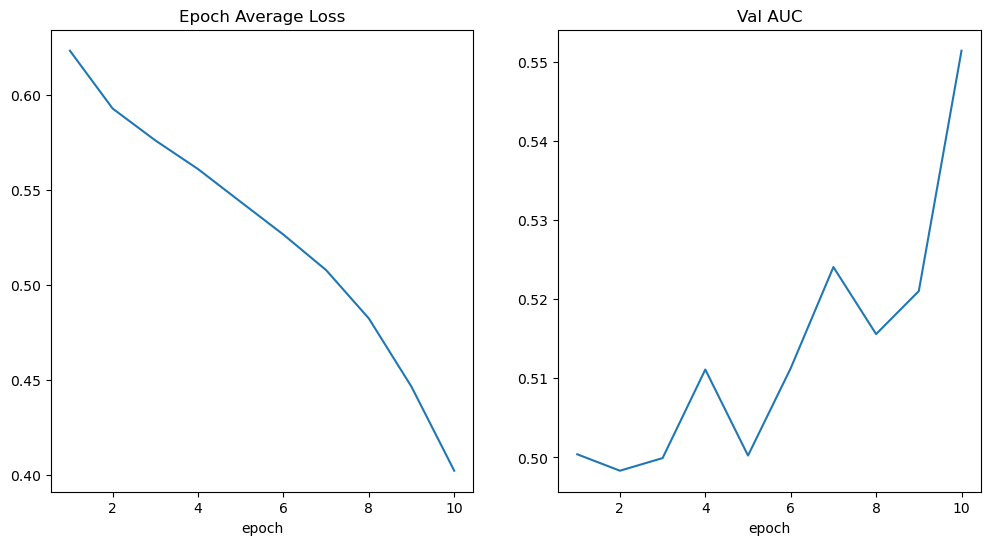

In [44]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

In [45]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [46]:
print(classification_report(
    y_true, y_pred, target_names=class_names, digits=4))

               precision    recall  f1-score   support

   depression     0.6949    0.9840    0.8146       125
no_depression     0.3333    0.0182    0.0345        55

     accuracy                         0.6889       180
    macro avg     0.5141    0.5011    0.4245       180
 weighted avg     0.5844    0.6889    0.5762       180

